In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pandas_profiling import ProfileReport
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [2]:
df = pd.read_csv('Data/healthcare-dataset-stroke-data.csv')
df.describe()

id          age  hypertension  heart_disease  \
count   5110.000000  5110.000000   5110.000000    5110.000000   
mean   36517.829354    43.226614      0.097456       0.054012   
std    21161.721625    22.612647      0.296607       0.226063   
min       67.000000     0.080000      0.000000       0.000000   
25%    17741.250000    25.000000      0.000000       0.000000   
50%    36932.000000    45.000000      0.000000       0.000000   
75%    54682.000000    61.000000      0.000000       0.000000   
max    72940.000000    82.000000      1.000000       1.000000   

       avg_glucose_level          bmi       stroke  
count        5110.000000  4909.000000  5110.000000  
mean          106.147677    28.893237     0.048728  
std            45.283560     7.854067     0.215320  
min            55.120000    10.300000     0.000000  
25%            77.245000    23.500000     0.000000  
50%            91.885000    28.100000     0.000000  
75%           114.090000    33.100000     0.000000  
max           271.740000    97.600000     1.000000

In [3]:
df['bmi']=df['bmi'].fillna(np.mean(df['bmi']))

In [4]:
pd.DataFrame({"number of null values":df.isna().sum()})

number of null values
id                                     0
gender                                 0
age                                    0
hypertension                           0
heart_disease                          0
ever_married                           0
work_type                              0
Residence_type                         0
avg_glucose_level                      0
bmi                                    0
smoking_status                         0
stroke                                 0

In [5]:
cat_cols = df.select_dtypes(include='object').columns.to_list()
cat_cols

['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']

In [6]:
num_cols = df.select_dtypes(exclude='object').columns.to_list()[1:]
num_cols

['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi', 'stroke']

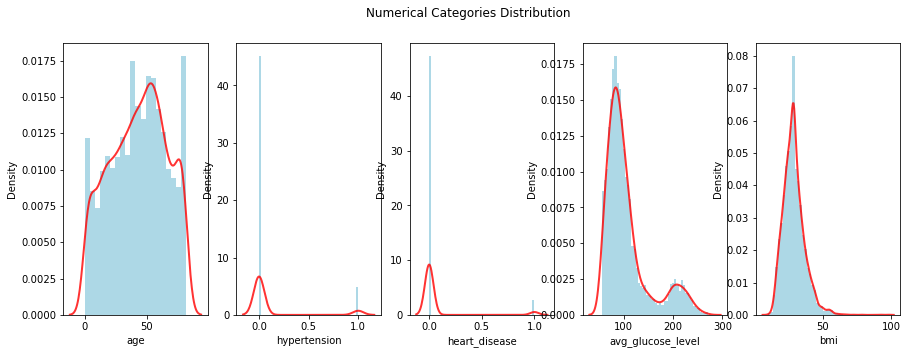

In [7]:
k=1
fig = plt.figure(figsize=(15,5))
fig.suptitle("Numerical Categories Distribution")

for col,k in zip(num_cols,np.arange(1,len(num_cols))):
    ax = fig.add_subplot(1,5,k)
    sns.distplot(df[col], ax=ax,kde=True, kde_kws={ "color":'r', "alpha": 0.8, "linewidth":2 }, hist_kws={ "linewidth": 3,
                            "alpha": 1, "color": "lightblue"} )
    fig.show()

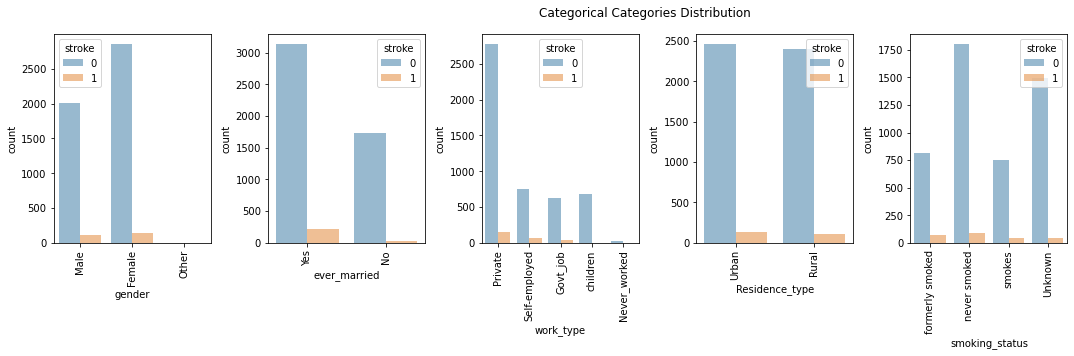

In [8]:
k=1
fig = plt.figure(figsize=(18,5))
fig.suptitle("Categorical Categories Distribution")

for col,k in zip(cat_cols,np.arange(1,len(cat_cols)+1)):
    ax = fig.add_subplot(1,6,k)
    sns.countplot(df[col], ax=ax, linewidth= 3, alpha= 0.5, hue=df['stroke'])
    plt.xticks(rotation=90)
    fig.tight_layout()
    fig.show()

<AxesSubplot:xlabel='work_type', ylabel='count'>

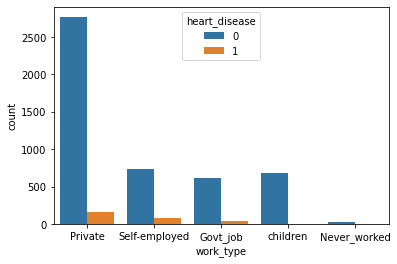

In [9]:
ax=sns.countplot(x=df['work_type'], hue=df['heart_disease'])
ax

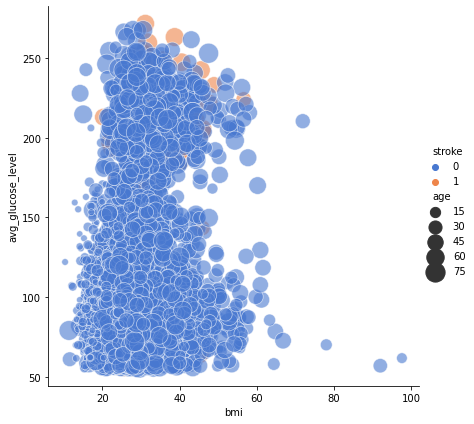

In [10]:
sns.relplot(x="bmi", y="avg_glucose_level", hue="stroke", size="age",
            sizes=(40, 400), alpha=0.6, palette="muted",
            height=6, data=df)

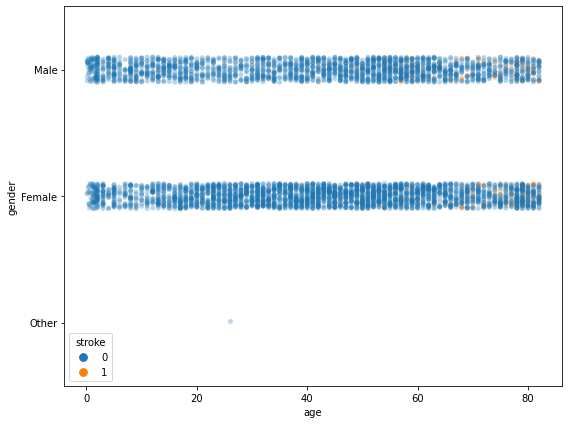

In [11]:
plt.figure(figsize=(8,6))

ax = sns.stripplot(y='gender', x='age', hue='stroke',alpha=0.3, data=df)
plt.tight_layout()

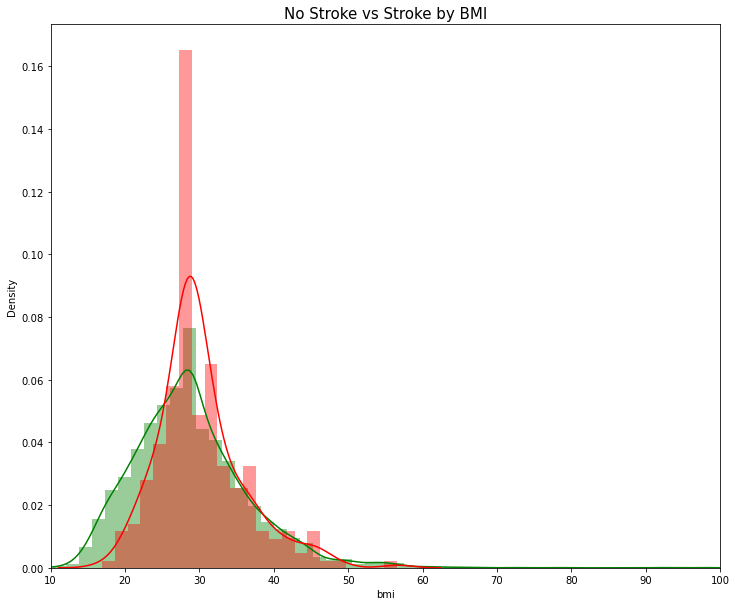

In [12]:
plt.figure(figsize=(12,10))

sns.distplot(df[df['stroke'] == 0]["bmi"], color='green') # No Stroke - green
sns.distplot(df[df['stroke'] == 1]["bmi"], color='red') # Stroke - Red

plt.title('No Stroke vs Stroke by BMI', fontsize=15)
plt.xlim([10,100])
plt.show()

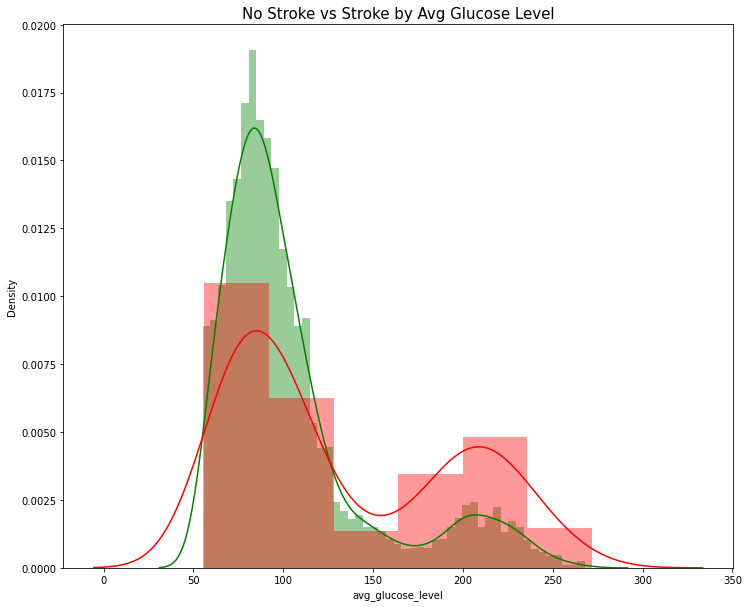

In [13]:
plt.figure(figsize=(12,10))

sns.distplot(df[df['stroke'] == 0]["avg_glucose_level"], color='green') # No Stroke - green
sns.distplot(df[df['stroke'] == 1]["avg_glucose_level"], color='red') # Stroke - Red

plt.title('No Stroke vs Stroke by Avg Glucose Level', fontsize=15)
plt.show()

In [14]:
y=df['stroke']

for feature in num_cols[:-1]:
    correlation=np.corrcoef(df[feature], y)[1][0]
    print(f"{feature} is correlated to stroke by a factor of {np.round(correlation,2)}")

age is correlated to stroke by a factor of 0.25
hypertension is correlated to stroke by a factor of 0.13
heart_disease is correlated to stroke by a factor of 0.13
avg_glucose_level is correlated to stroke by a factor of 0.13
bmi is correlated to stroke by a factor of 0.04


### Data processing 

In [15]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

In [16]:
df= pd.get_dummies(df)

x=df.drop('stroke', axis=1)
y=df['stroke']

In [17]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size= 0.2, random_state= 0)

### Standardization 

In [18]:
from sklearn.preprocessing import StandardScaler 

sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

In [19]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=2)
x_train_res, y_train_res = sm.fit_resample(x_train, y_train.ravel())

### Model comparisons

In [21]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier


from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, ConfusionMatrixDisplay,RocCurveDisplay, precision_score, recall_score, f1_score, classification_report, roc_curve, plot_roc_curve, auc, precision_recall_curve, plot_precision_recall_curve, average_precision_score
from sklearn.model_selection import cross_val_score

In [22]:
models=[]
model_score=[]
models.append(['Logistic Regression', LogisticRegressionCV(cv=8, random_state=0)])
models.append(['KNeighborsClassifier', KNeighborsClassifier(n_neighbors=3, weights='distance')])
models.append(['GaussianNB', GaussianNB()])
models.append(['BernoulliNB', BernoulliNB()])
models.append(['DecisionTreeClassifier', DecisionTreeClassifier(criterion='entropy', max_depth= 4)])
models.append(['RandomForestClassifier', RandomForestClassifier(n_estimators=50)])
models.append(['XGBClassifier', XGBClassifier(eval_metric= 'error')])
models.append(['SVC',SVC(kernel='linear', degree=4)])
models.append(['Extra Tree Classifier',ExtraTreeClassifier(random_state=0)])
models.append(['Ada Boost Classifier',AdaBoostClassifier(random_state=0)])

----------------------------------------------------------------------------------------------
Logistic Regression :
---------------------------------------------
Accuracy Score : 0.9471624266144814

K Fold Accuracy : 95.18

F1 Score : 0.0

Recall : 0.0

ROC :0.5

Confusion Matrix : 

[[968   0]
 [ 54   0]]



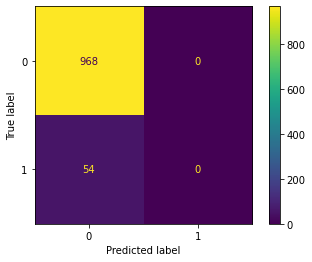

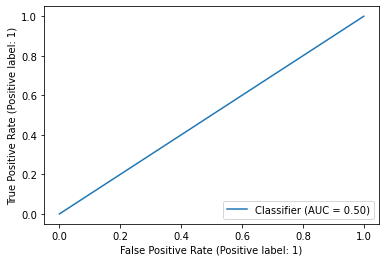

----------------------------------------------------------------------------------------------
KNeighborsClassifier :
---------------------------------------------
Accuracy Score : 0.9403131115459883

K Fold Accuracy : 94.13

F1 Score : 0.08955223880597016

Recall : 0.05555555555555555

ROC :0.5226124885215795

Confusion Matrix : 

[[958  10]
 [ 51   3]]



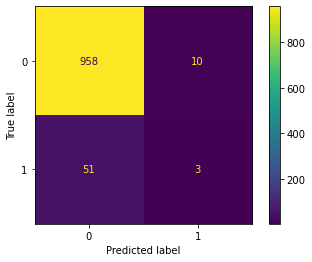

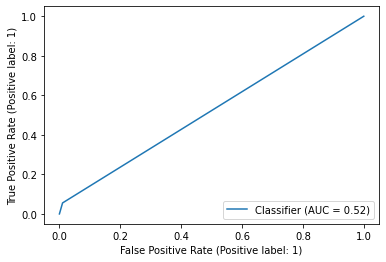

----------------------------------------------------------------------------------------------
GaussianNB :
---------------------------------------------
Accuracy Score : 0.19275929549902152

K Fold Accuracy : 18.57

F1 Score : 0.11194833153928956

Recall : 0.9629629629629629

ROC :0.5563781756963575

Confusion Matrix : 

[[145 823]
 [  2  52]]



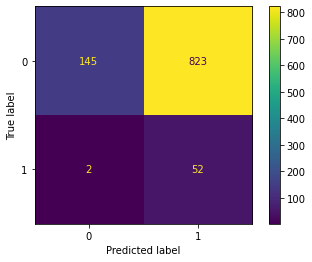

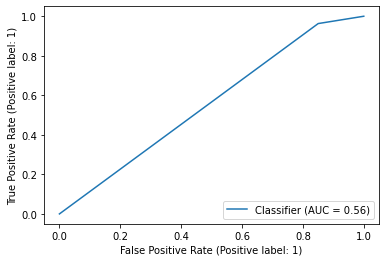

----------------------------------------------------------------------------------------------
BernoulliNB :
---------------------------------------------
Accuracy Score : 0.9178082191780822

K Fold Accuracy : 92.59

F1 Score : 0.125

Recall : 0.1111111111111111

ROC :0.5369605142332415

Confusion Matrix : 

[[932  36]
 [ 48   6]]



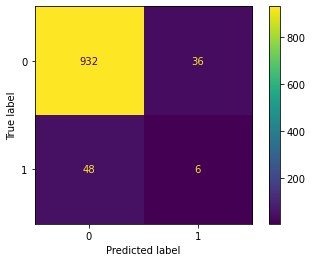

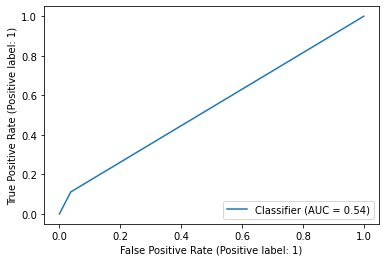

----------------------------------------------------------------------------------------------
DecisionTreeClassifier :
---------------------------------------------
Accuracy Score : 0.9461839530332681

K Fold Accuracy : 95.16

F1 Score : 0.0

Recall : 0.0

ROC :0.4994834710743802

Confusion Matrix : 

[[967   1]
 [ 54   0]]



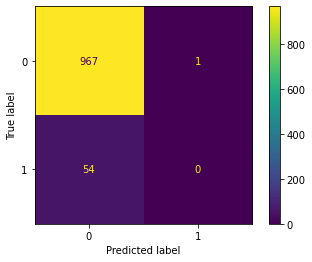

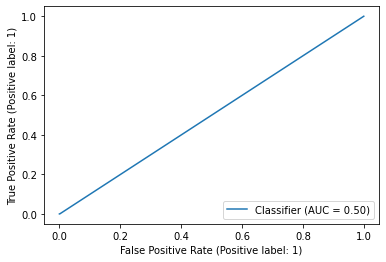

----------------------------------------------------------------------------------------------
RandomForestClassifier :
---------------------------------------------
Accuracy Score : 0.9461839530332681

K Fold Accuracy : 95.11

F1 Score : 0.0

Recall : 0.0

ROC :0.4994834710743802

Confusion Matrix : 

[[967   1]
 [ 54   0]]



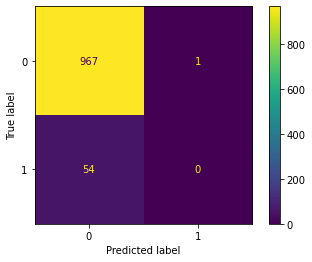

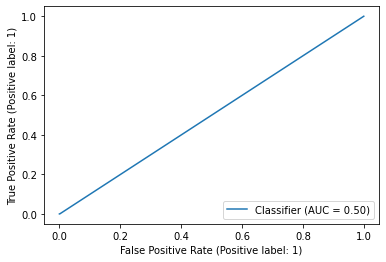

----------------------------------------------------------------------------------------------
XGBClassifier :
---------------------------------------------
Accuracy Score : 0.9432485322896281

K Fold Accuracy : 94.64

F1 Score : 0.06451612903225806

Recall : 0.037037037037037035

ROC :0.5154193449647995

Confusion Matrix : 

[[962   6]
 [ 52   2]]



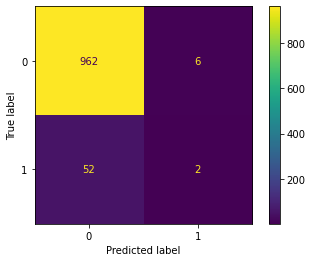

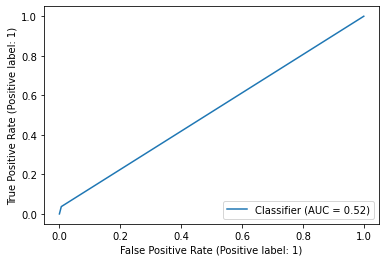

----------------------------------------------------------------------------------------------
SVC :
---------------------------------------------
Accuracy Score : 0.9471624266144814

K Fold Accuracy : 95.23

F1 Score : 0.0

Recall : 0.0

ROC :0.5

Confusion Matrix : 

[[968   0]
 [ 54   0]]



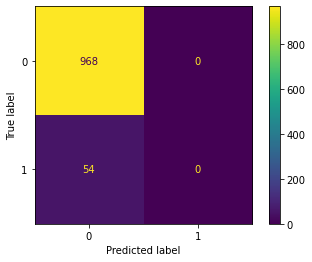

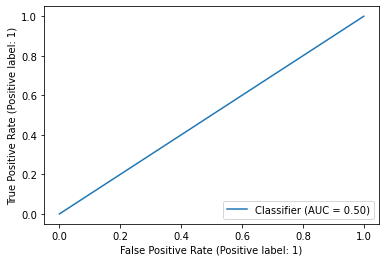

----------------------------------------------------------------------------------------------
Extra Tree Classifier :
---------------------------------------------
Accuracy Score : 0.913894324853229

K Fold Accuracy : 91.12

F1 Score : 0.15384615384615383

Recall : 0.14814814814814814

ROC :0.552379859198041

Confusion Matrix : 

[[926  42]
 [ 46   8]]



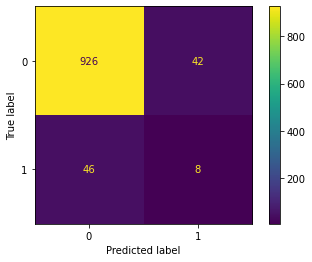

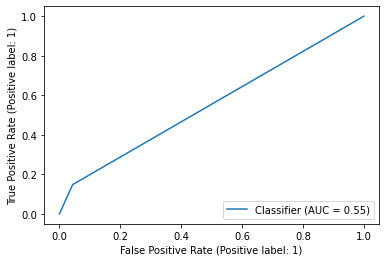

----------------------------------------------------------------------------------------------
Ada Boost Classifier :
---------------------------------------------
Accuracy Score : 0.9452054794520548

K Fold Accuracy : 94.96

F1 Score : 0.034482758620689655

Recall : 0.018518518518518517

ROC :0.5077096724823997

Confusion Matrix : 

[[965   3]
 [ 53   1]]



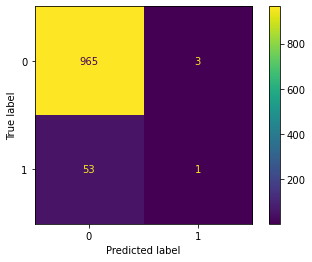

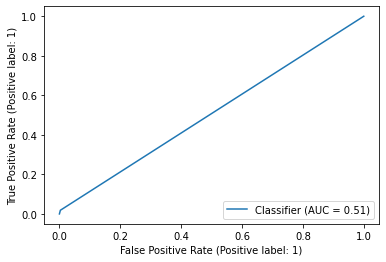

In [23]:
for model in models:
        model_data=[]
        model[1].fit(x_train, y_train)
        y_pred = model[1].predict(x_test)
        acc_score = accuracy_score(y_test, y_pred)
        report = classification_report(y_test,y_pred, output_dict=True)
        conf_matrix = confusion_matrix(y_test,y_pred)
        f1= f1_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        roc = roc_auc_score(y_test, y_pred)
        accuracies = cross_val_score(estimator = model[1], X = x_train, y = y_train, cv = 5)   #K-Fold Validation
        print('----------------------------------------------------------------------------------------------')
        print(f'{model[0]} :')
        print('---------------------------------------------')
        print(f'Accuracy Score : {acc_score}')
        print('')
        print(f'K Fold Accuracy : {accuracies.mean()*100:.2f}')
        print('')
        print(f'F1 Score : {f1}')
        print('')
        print(f'Recall : {recall}')
        print('')
        print(f'ROC :{roc}')
        print('')
        print(f'Confusion Matrix : ')
        print('')
        print(f'{conf_matrix}')
        print('')
        model_data.append(model[0])
        model_data.append(acc_score)
        model_score.append(model_data)
        ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
        RocCurveDisplay.from_predictions(y_test, y_pred)
        plt.show()

In [24]:
model_accuracies = pd.DataFrame(model_score,columns=['Model', 'Accuracy'])
model_accuracies.sort_values(by='Accuracy', ascending=False)

Model  Accuracy
0     Logistic Regression  0.947162
7                     SVC  0.947162
4  DecisionTreeClassifier  0.946184
5  RandomForestClassifier  0.946184
9    Ada Boost Classifier  0.945205
6           XGBClassifier  0.943249
1    KNeighborsClassifier  0.940313
3             BernoulliNB  0.917808
8   Extra Tree Classifier  0.913894
2              GaussianNB  0.192759

In [25]:
from sklearn.model_selection import GridSearchCV


gridmodels=[(LogisticRegressionCV(),[{'cv': [5,6,8,10,15], 'random_state':[0,10]}]),
            (RandomForestClassifier(), [{'n_estimators': [10,25,50,75,100]}]),
            (SVC(), [{'degree': [2,3,4,5]}])
]

### The Best parameters

In [26]:
for gridmodel in gridmodels:
    grid = GridSearchCV(estimator=gridmodel[0],param_grid = gridmodel[1], scoring = 'accuracy',cv = 10)
    grid.fit(x_train, y_train)
    best_accuracy = grid.best_score_
    best_param = grid.best_params_
    print('{}:\nBest Accuracy : {:.2f}%'.format(gridmodel[0],best_accuracy*100))
    print('Best Parameters : ',best_param)
    print('')
    print('----------------')
    print('')

LogisticRegressionCV():
Best Accuracy : 95.23%
Best Parameters :  {'cv': 5, 'random_state': 0}

----------------

RandomForestClassifier():
Best Accuracy : 95.16%
Best Parameters :  {'n_estimators': 50}

----------------

SVC():
Best Accuracy : 95.23%
Best Parameters :  {'degree': 2}

----------------

